# analyze_rdfs.ipynb
---

TODO:
- [ ] import fit funcs from btl

In [1]:
import os
import sys
import math
from pathlib import Path

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import ROOT as rt
from ROOT import gROOT
from ROOT import TMath

from ROOT import TFile, TNtuple, TTree, RDataFrame
from ROOT import TCanvas, TLegend, TLatex, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors
from ROOT import TF1, TMath

ROOT_ERROR_LEVEL = {'QUIET':1001,'NORMAL':None,'VERBOSE':None}['QUIET']
ROOT_BATCH = True #! this should be true
rt.EnableImplicitMT()

rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL
rt.gROOT.SetBatch(ROOT_BATCH)
rt.gStyle.SetOptFit(0)
rt.gStyle.SetOptStat(0)

gc = [] # ROOT Garbage Collector

STD_COLOR_LIST = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 30, 40, 42, 49, 46, 38, 32, 800, 600, 900, 870, 840]

####

SOURCES = {'spe':1, 'sodium' : 511, 'cesium' : 662, 'cobalt' : 122}
ATTENUATION_FACTOR = 5.85

####

DATA_DIR = '/home/psimmerl/module_testing/data/scan'
PLOT_DIR = '/home/psimmerl/module_testing/notebooks/plots/analyze_rdfs'
Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)

modules = []

files_names = [fn for fn in os.listdir(DATA_DIR) if '_RDF.root' in fn]
for ifn, fn in enumerate(files_names):
    # if len(modules) >= 2:
    #     continue
    print(f'{ifn+1:>3}/{len(files_names)} : {fn}')
    fn_split = fn.rstrip('_RDF.root').split('_')

    aliases = {
        'channelTriggered' : 'trg',
        'IntegratedCharge' : 'charge',
    }
    # # **** #
    # opts = rt.RDF.RSnapshotOptions()
    # opts.fMode, opts.fOverwriteIfExists = 'update', True
    # for source in ('spe', 'sodium'):
    #     d = {}
    #     rdfs = [
    #         RDataFrame(f'{source}_TriggerGroup1', f'{DATA_DIR}/{fn}'),
    #         RDataFrame(f'{source}_TriggerGroup2', f'{DATA_DIR}/{fn}'),
    #         RDataFrame(f'{source}_TriggerGroup3', f'{DATA_DIR}/{fn}'),
    #         RDataFrame(f'{source}_TriggerGroup4', f'{DATA_DIR}/{fn}'),
    #     ]
    #     for irdf, rdf in enumerate(rdfs):
    #         print(f'\t{source}_TriggerGroup{irdf+1}')
    #         if 'channelTriggered' in d:
    #             pad_array = np.zeros_like(d['channelTriggered'])
    #         d_group = rdf.AsNumpy()
    #         for k, v in d_group.items():
    #             if 'satFlag' in k:
    #                 continue
    #             if k in d: # only really channelTriggerered
    #                 d[k] = np.append(d[k], v)
    #             else:
    #                 if 'channelTriggered' in d: # new channels being added as columns
    #                     d[k] = np.append(pad_array, v)
    #                 else: # happens with the first rdf only
    #                     d[k] = v
    #         pad_array = np.zeros_like(d_group['channelTriggered'])
    #         for k, v in d.items():
    #             if 'satFlag' in k:
    #                 continue
    #             if k not in d_group: # pad all the channels that we dont see anymore
    #                 d[k] = np.append(v, pad_array)
    #     for k in list(d.keys()):
    #         if 'satFlag' in k:
    #             continue
    #         if k in aliases:
    #             d[k.replace(k, aliases[k])] = v
    #             del d[k]
    #         elif k.split('_')[-1] in aliases:
    #             d[k.replace(k.split('_')[-1], aliases[k.split('_')[-1]])] = v
    #             del d[k]

    #     rdf = rt.RDF.FromNumpy(d)
    #     rdf.Snapshot(f'{source}_events', f'{DATA_DIR}/{fn}', '', opts)
    #     del d
    #     del rdf
    # # **** #

    module = {
        'id' : fn_split[1],
        'ov' : float(fn_split[2][3:]),
        'tt' : -1*abs(float(fn_split[3][3:])),
        'nspe' : int(fn_split[4][4:]),
        'nsrc' : int(fn_split[5][7:]),
        'source' : 'sodium',
        ####
        # 'rdf_spe' : RDataFrame('spe_events', f'{DATA_DIR}/{fn}'),
        # 'rdf_src' : RDataFrame('sodium_events', f'{DATA_DIR}/{fn}'),
        ####
        'spe_rdfs' : [
            RDataFrame('spe_TriggerGroup1', f'{DATA_DIR}/{fn}'),
            RDataFrame('spe_TriggerGroup2', f'{DATA_DIR}/{fn}'),
            RDataFrame('spe_TriggerGroup3', f'{DATA_DIR}/{fn}'),
            RDataFrame('spe_TriggerGroup4', f'{DATA_DIR}/{fn}'),
        ],
        'src_rdfs' : [
            RDataFrame('sodium_TriggerGroup1', f'{DATA_DIR}/{fn}'),
            RDataFrame('sodium_TriggerGroup2', f'{DATA_DIR}/{fn}'),
            RDataFrame('sodium_TriggerGroup3', f'{DATA_DIR}/{fn}'),
            RDataFrame('sodium_TriggerGroup4', f'{DATA_DIR}/{fn}'),
        ],
        ####
        'spe_charge' : np.zeros((32,2), dtype=float), # 32 channels x (value, errror)
        'src_charge' : np.zeros((32,2), dtype=float), # 32 channels x (value, errror)
    }

    for k in module:
        if 'rdfs' not in k:
            continue

        for irdf in range(len(module[k])):
            for c in module[k][irdf].GetColumnNames():
                c = str(c)
                if '_t90' in c:
                    module[k][irdf] = module[k][irdf].Define(c[:-2], f'{c} - {c[:-2]}10')

                if c in aliases:
                    module[k][irdf] = module[k][irdf].Alias(aliases[c], c)
                elif c.split('_')[-1] in aliases:
                    module[k][irdf] = module[k][irdf].Alias('_'.join(c.split('_')[:-1] + [aliases[c.split('_')[-1]]]), c)


    modules.append(module)

print(f'Loaded {len(modules)} OV/TT scans')


Welcome to JupyROOT 6.30/02
  1/55 : module_200041_Vov2.00_Vtt0.090_Nspe100000_Nsource200000_RDF.root
  2/55 : module_200041_Vov2.40_Vtt0.080_Nspe100000_Nsource200000_RDF.root
  3/55 : module_200041_Vov2.40_Vtt0.025_Nspe100000_Nsource200000_RDF.root
  4/55 : module_200041_Vov3.00_Vtt0.035_Nspe100000_Nsource200000_RDF.root
  5/55 : module_200041_Vov3.00_Vtt0.020_Nspe100000_Nsource200000_RDF.root
  6/55 : module_200041_Vov2.80_Vtt0.015_Nspe100000_Nsource200000_RDF.root
  7/55 : module_200041_Vov2.80_Vtt0.040_Nspe100000_Nsource200000_RDF.root
  8/55 : module_200041_Vov1.20_Vtt0.005_Nspe100000_Nsource200000_RDF.root
  9/55 : module_200041_Vov2.60_Vtt0.070_Nspe100000_Nsource200000_RDF.root
 10/55 : module_200041_Vov2.80_Vtt0.005_Nspe100000_Nsource200000_RDF.root
 11/55 : module_200041_Vov1.40_Vtt0.040_Nspe100000_Nsource200000_RDF.root
 12/55 : module_200041_Vov2.40_Vtt0.055_Nspe100000_Nsource200000_RDF.root
 13/55 : module_200041_Vov3.00_Vtt0.090_Nspe100000_Nsource200000_RDF.root
 14/55 : m

# Scan Log

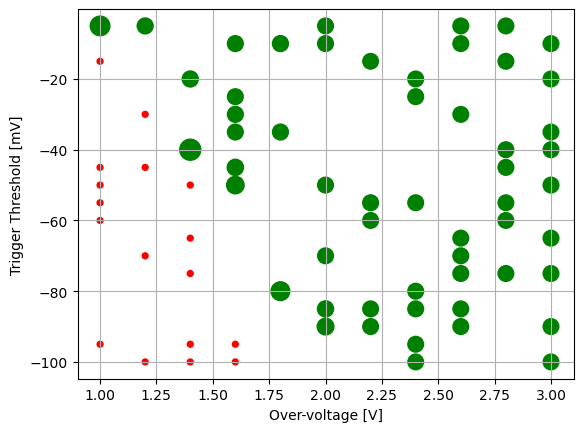

In [2]:
scan_log = []

with open(f'{DATA_DIR}/scan_log.csv', 'r') as f:
    for line in f:
        if 'ov' in line:
            continue
        scan_log.append([float(x) for x in line.split(',')])
scan_log = np.array(scan_log)

pass_idx = scan_log[:,2]<3600
plt.scatter(scan_log[pass_idx,0],1000*scan_log[pass_idx,1], s=scan_log[pass_idx,2]/10, c='g', label='collected')
plt.scatter(scan_log[~pass_idx,0],1000*scan_log[~pass_idx,1], s=scan_log[~pass_idx,2]/200, c='r', label='timed out')
plt.xlabel('Over-voltage [V]')
plt.ylabel('Trigger Threshold [mV]')
plt.grid()
# plt.legend(loc='lower left')

(0.0, 65.0)

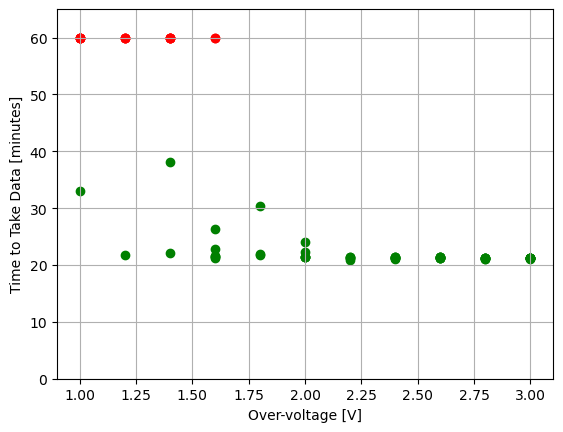

In [3]:
pass_idx = scan_log[:,2]<3600
plt.scatter(scan_log[pass_idx,0],scan_log[pass_idx,2]/60, c='g', label='collected')
plt.scatter(scan_log[~pass_idx,0],scan_log[~pass_idx,2]/60, c='r', label='timed out')
plt.xlabel('Over-voltage [V]')
plt.ylabel('Time to Take Data [minutes]')
plt.grid()
plt.ylim(0, 65)
# plt.legend(loc='lower left')

# Charge Spectra Fit & Plots

## Fit Functions & Helpers


In [4]:
"""Single Photoelection fit function
"""
from scipy.stats import poisson
from scipy.special import gamma
from functools import lru_cache, wraps

# DEFAULT VALUES FOR SPE FIT:
D_OFFSET = 0
D_LAMBDA = 0.5
D_SPE_CHARGE = 0.8
D_NOISE_SPREAD = 0.01
D_SPE_CHARGE_SPREAD = 0
D_ZERO_PEAK_SPREAD = 0.4
# Number of peaks we use for SPE fitting
num_peaks = 20

ROOT_FUNC = "[0]*(" + "+".join(["TMath::Poisson(%i,[2])*TMath::Gaus(x-[1],[3]*%i,TMath::Sqrt([4]^2+[5]^2*%i))" % (i,i,i) for i in range(0,num_peaks)]) + ")"

def get_bin_num(h, val):
    """
    Gets the bin number of `val` if `val` was placed into the histogram `h`.
    Does NOT add `val` to `h`.
    """
    return h.GetXaxis().FindBin(val)

def fac(x):
    """
    Returns x!. We use the gamma function here instead since it works even for
    non-integer values and is generally faster than calling math.factorial(x).
    """
    return gamma(x+1)

@lru_cache(maxsize=None)
def vinogradov_fast(N, l, ps):
    """
    Returns probability of getting `N` PEs in the integration window.  `l` is
    the mean number of primary PEs.  `ps` is the probability that a primary PE
    causes a secondary PE.  See this paper for a more detailed explanation:
    https://arxiv.org/pdf/2106.13168.pdf
    """
    i = np.arange(N+1)
    return np.exp(-l)*(B_coeff_fast(i, N) * (l*(1-ps))**i * ps**(N-i)).sum()/fac(N)

def vinogradov(N, l, ps):
    """
    Returns probability of getting `N` PEs in the integration window.  `l` is
    the mean number of primary PEs.  `ps` is the probability that a primary PE
    causes a secondary PE.  See this paper for a more detailed explanation:
    https://arxiv.org/pdf/2106.13168.pdf
    """
    model = 0
    for i in range(N+1):
        model += B_coeff(i, N) * (l*(1-ps))**i * ps**(N-i)
    model *= np.exp(-l)
    model /= fac(N)
    return model

def B_coeff_fast(i, N):
    """
    Helper function for the vinogradov model.
    """
    i = np.atleast_1d(i)
    rv = np.empty_like(i)
    rv[(i == 0) & (N == 0)] = 1
    rv[(i == 0) & (N > 0)] = 0
    if (i > 0).any():
        rv[i > 0] = (fac(N)*fac(N-1)) / (fac(i[i > 0])*fac(i[i > 0]-1)*fac(N-i[i > 0]))
    return rv

def B_coeff(i, N):
    """
    Helper function for the vinogradov model.
    """
    if i == 0 and N == 0:
        return 1
    elif i == 0 and N > 0:
        return 0
    else:
        return (fac(N)*fac(N-1)) / (fac(i)*fac(i-1)*fac(N-i))

class vinogradov_model:
    """
    We assume that each photoelectron (PE) peak is gaussian. We add the PE
    distributions together, each weighted by a probability given by
    `vinogradov`. The whole distribution is then convolved with a single
    gaussian to model the noise of the signal.
    
    p[0]: overall scale
    p[1]: offset
    p[2]: mean number of SPEs in integration window
    p[3]: SPE charge
    p[4]: std. of scope/digitizer noise
    p[5]: std. of SPE charge
    p[6]: probability that a primary PE triggers a secondary PE (https://arxiv.org/pdf/2106.13168.pdf)
    """
    def __call__(self, x, p):
        model = 0
        for i in range(num_peaks):
            coefficient = vinogradov_fast(i, p[2], p[6])
            if i > 1 and coefficient < 1e-3:
                break
            model += coefficient * TMath.Gaus(x[0]-p[1], i*p[3], TMath.Sqrt(p[4]**2 + i*(p[5]**2)), False)
        model *= p[0]
        return model

def fit_spe(h, model, f_h=None, root_func=False):
    """ 
    SPE Fitting Strategy
    
    1. We use a 7 parameter model to fit the SPE charge histogram.
       See `vinogradov_model` in this module for an explanation.
    
    2. We find the location of the peak corresponding to zero SPE events by
       fitting a gaussian to the lowest charge peak we find in the histogram.
       This gives us an estimate of the offset and background noise parameters.i

    3. We estimate the average number of SPEs in the integration
       window (`l`) as follows:
       4.1. Count all the entries in the zero peak
       4.2. Divide by total entries, giving probability that there
            are no SPEs in the integration window: P(no SPEs).
       4.3. The vinogradov distribution is approximately poisson.
            Since a poisson distribution only depends on its mean,
            having P(no SPEs) gives us `l`.
    
    4. The SPE charge (mu) is estimated using this equation:
       h.GetMean() = P(no SPEs)*(offset) + P(1 SPE)*(mu + offset) + P(2 SPEs)*(2*mu + offset) + ...
    
    5. Two fits are preformed. The first fit keeps several
       parameters fixed so that we get distinguishable peaks. The
       second fit releases most parameters to preform a final, clean
       fit of everything. Exactly which parameters get fixed or
       relased is still under active development as of the time of
       this comment: Aug. 5, 2022.

    If the fit is successful, returns the list of fit parameters, otherwise
    returns None.
    """
    offset = D_OFFSET
    raw_spread = D_ZERO_PEAK_SPREAD
    scale = h.GetEntries()*0.075
    if f_h:
        print('Ignoring filtered data; outdated procedure')

    # Try to guess the offset by looking for the highest peak less than zero
    xmax = None
    ymax = 0
    for i in range(1,h.GetNbinsX()-1):
        x = h.GetBinCenter(i)

        value = h.GetBinContent(i)

        if x < 1 and value > ymax:
            xmax = x
            ymax = value

        # Depending on binning, this may break too early
        # if value < ymax*0.8:
        #     break

    if xmax is None:
        return None

    offset = xmax
    
    f_noise = rt.TF1('f_noise', 'gaus', xmax - 0.5, xmax + 0.5)
    f_noise.SetParameter(1,offset)
    f_noise.FixParameter(1,offset)
    f_noise.SetParameter(2,0.1)
    f_noise.SetParLimits(2,0.01,10)
    h.Fit(f_noise, 'SRQ0')
    f_noise.ReleaseParameter(1)
    h.Fit(f_noise, 'SRQ0')
    offset = f_noise.GetParameter(1)
    raw_spread = f_noise.GetParameter(2)

    # Probability that an SPE trigger a secondary SPE
    ps = 0

    # `l`, short for lambda, which is the average number of PEs measured in the
    # integration window.
    zero_peak_end = offset + 2 * raw_spread
    num_zero = h.Integral(0, get_bin_num(h, zero_peak_end))
    prob_zero = num_zero / h.GetEntries()
    if prob_zero <= 0 or prob_zero >= 1:
        l = D_LAMBDA
    else:
        l = -np.log(prob_zero)
    num_peaks = min(20, max(4, int(poisson.ppf(0.95, l))))

    # SPE Charge estimated using the method from this forum:
    # https://math.stackexchange.com/questions/3689141/calculating-the-mean-and-standard-deviation-of-a-gaussian-mixture-model-of-two-c
    SPE_charge = h.GetMean()
    SPE_charge -= offset * sum([vinogradov(i, l, ps) for i in range(num_peaks)])
    SPE_charge /= sum([vinogradov(i, l, ps) * i for i in range(num_peaks)])
    SPE_charge = min(4, SPE_charge)
    SPE_charge = max(zero_peak_end - offset, SPE_charge)

    if root_func:
        raise Exception('idk if this works')
        # f1 = rt.TF1("%s_fit" % h.GetName(), string, offset - 1.5*raw_spread, offset + 5*h.GetStdDev())
    else:
        # Number of parameters must be specified when using a python function
        f1 = rt.TF1("%s_fit" % h.GetName(), model, offset - 1.5*raw_spread, offset + 5*h.GetStdDev(), 7)

    f1.SetParameter(0, scale)
    f1.SetParLimits(0, 0, 1e9)

    f1.FixParameter(1, offset)

    f1.SetParameter(2, l)
    f1.SetParLimits(2, 0, num_peaks+5)

    f1.SetParameter(3, SPE_charge)
    f1.SetParLimits(3, zero_peak_end - offset, SPE_charge + 1)
    f1.FixParameter(4, raw_spread)
    
    f1.FixParameter(5, D_SPE_CHARGE_SPREAD)
    
    f1.FixParameter(6, ps)
    f1.FixParameter(7, 0)

    for i in range(6):
        print(f'[{i}]: {f1.GetParameter(i)}')
    
    r = h.Fit(f1, 'SRB')

    h.SetAxisRange(0, h.GetBinContent(h.GetMaximumBin())+h.GetEntries()*0.0025, "Y")
    h.Write()

    for i in range(7):
        f1.ReleaseParameter(i)

    f1.SetParLimits(2, max(0, f1.GetParameter(2) - 1), f1.GetParameter(2) + 1)
    f1.SetParLimits(3, max(zero_peak_end-offset, f1.GetParameter(3) - 1), f1.GetParameter(3) + 1)
    f1.SetParLimits(4, 0, 10)
    f1.SetParLimits(5, 0, 0.5) 
    f1.SetParLimits(6, 0, 0.5)

    r = h.Fit(f1, 'SR')
    r = r.Get()
    if not r.IsValid():
        print("Fit error!")
        return None
    
    h.SetAxisRange(0, h.GetBinContent(h.GetMaximumBin())+h.GetEntries()*0.0025, "Y")
    f1.Write()
    h.Write()

    return [f1.GetParameter(i) for i in range(7)], [f1.GetParError(i) for i in range(7)]


In [5]:
"""Source fit function
gaus + linear background
"""
def gaus(x, mu=0, sig=1):
    return 1/(sig*(2*math.pi)**0.5) * math.exp(-0.5*((x-mu)/sig)**2)

def fit_gamma(hist, pol=2):
    '''gaussian + polynomial background'''
    def bc(bin):
        return hist.GetBinCenter(bin)
    def bv(x):
        return hist.GetBinContent(hist.FindBin(x))

    NS = 2
    for i in range(3):
        if i == 0:
            centers = np.array([hist.GetBinCenter(ibin) for ibin in range(1, hist.GetNbinsX())])
            content = np.array([hist.GetBinContent(ibin) for ibin in range(1, hist.GetNbinsX())])
            A, mu = 0, 0
            for ic, (ce, co) in enumerate(zip(centers[::-1], content[::-1])):
                if ic < 15:
                    continue
                left = np.mean(content[::-1][ic:ic+15])
                right = np.mean(content[::-1][ic-15:ic])
                center = np.mean(content[::-1][ic-5:ic+5])
                if center > left and center > right and center > np.mean(content) and abs(left-right)*2/(left+right) < 0.1:# and center > A:
                    mu, A = ce, co
                    break
            sig, p0, p1, p2 = 0, 0, 0, 0

        aa = A/2+p0+p1*(mu+sig*(2*math.log(2))**0.5)
        x_fwhm = bc(hist.FindLastBinAbove(aa))
        fwhm = abs((x_fwhm-mu)) * 2
        sig = fwhm / (2*(2*math.log(2))**0.5)

        A = gaus(0) * (bv(mu) - (bv(mu-NS*sig)+bv(mu+NS*sig))/2) / ( gaus(0) - gaus(NS) )
        p1 = (bv(mu+NS*sig)-bv(mu-NS*sig)) / (2*NS*sig)
        p0 = bv(mu) - (A + p1*mu)

    for source in SOURCES:
        if source in hist.GetName():
            eng = SOURCES[source]
            mu /= eng

    offset = 0 # also will need to fix
    fit_eq = f'[2]*exp(-0.5*(x-{offset}-[0]*{eng})**2/[1]**2) + [3] - [4]*x'# + [5]*x*x'

    for i in range(3):
        xl, xh = mu*eng - NS*sig, mu*eng + NS*sig
        fit = TF1(f'{hist.GetName()}_fit{i}',fit_eq, xl, xh)
        fit.SetParLimits(0, mu*2/3, mu*4/3)
        fit.SetParLimits(1, sig*2/3, sig*4/3)
        fit.SetParLimits(2, A*2/3, A*4/3)
        fit.SetParLimits(3, 0, p0*4/3)
        fit.SetParLimits(4, 0, p1*4/3)

        fit.SetParameters(mu, sig, A, p0, p1)#, p2)
        hist.Fit(fit, 'QM0', '', xl, xh)
        # hist.GetListOfFunctions()[-1] = fit
        mu = fit.GetParameter(0)
        sig = fit.GetParameter(1)
        A = fit.GetParameter(2)
        p0 = fit.GetParameter(3)
        p1 = fit.GetParameter(4)

    return mu, fit.GetParError(0), sig, A, p0, p1

## Fitting Spectra

In [6]:
logy = False
bins = {
    'spe' : (200, -2, 3.5),
    'sodium' : (200, 0, 1000),
}
# **** #
canvas = TCanvas('','',int(4*800 * 16/9), 4*800)

for imod, module in enumerate(modules):
    mid, ov, tt = module['id'], module['ov'], module['tt']

    for k, rdfs in module.items():
        if 'rdf' not in k:
            continue

        source = k.split('_')[0]
        if source in ('src', 'source'):
            source = module['source']

        canvas.Clear()
        canvas.Divide(4, 4)

        hmax, hists = 0, []
        for ich in range(32):
            print(f'{mid=} ({imod+1}/{len(modules)}): {tt=:.3f}, {ov=:.3f} | {source=}, {ich=}')
            bar = (ich if ich < 16 else 31-ich)
            rdf = rdfs[ich // 8]

            hname = f'h_ch{ich}_{source}_spectra'
            htitle = f'{source.capitalize()} Spectra for Module {mid}, ch{ich} (V_{{OV}}={ov:.2f}, V_{{TT}}={tt:.3f});Charge [pC];count'

            if source == 'spe':
                h = rdf.Histo1D((hname, htitle, *bins[source]), f'ch{ich}_charge')
                # model = vinogradov_model()
                # fit_pars = fit_spe(h, model)
                # module['spe_charge'][ich] = [fit_pars[0][3], fit_pars[1][3]]
            else:
                h = rdf.Filter(f'trg == {ich}').Histo1D((hname, htitle, *bins[source]), f'ch{ich}_charge')
                if module['src_charge'][ich][0] == 0:
                    fit_pars = fit_gamma(h)
                    module['src_charge'][ich] = [
                        fit_pars[0]*SOURCES[source]*1000*ATTENUATION_FACTOR, 
                        fit_pars[1]*SOURCES[source]*1000*ATTENUATION_FACTOR
                    ]
                h.SetLineColor([rt.kBlue, rt.kRed][ich < 16])
            h.SetLineWidth(3)
            hmax = max(hmax, h.GetMaximum())
            hists.append([bar,h])
            gc.append(h)

        for ipad, h in hists:
            canvas.cd(ipad + 1).SetGrid()
            canvas.cd(ipad + 1).SetRightMargin(0.001)
            if logy:
                canvas.cd(bar + 1).SetLogy(rt.kTrue)
            h.SetMaximum(hmax * 1.1)
            h.Draw('same')
            if len(h.GetListOfFunctions()):
                fit = h.GetListOfFunctions()[-1]
                fit.SetLineColor(rt.kMagenta)
                fit.SetLineWidth(3)
                fit.Draw('same')

        print(f'{PLOT_DIR}/module_{mid}_Vov{ov}_Vtt{tt}_{source}_spectra.png')
        # canvas.Draw()
        canvas.Print(f'{PLOT_DIR}/module_{mid}_Vov{ov}_Vtt{tt}_{source}_spectra.png')
        gc = []


mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=0
mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=1
mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=2
mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=3
mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=4
mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=5
mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=6
mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=7
mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=8
mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=9
mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=10
mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=11
mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=12
mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=13
mid='200041' (1/55): tt=-0.090, ov=2.000 | source='spe', ich=14
mid='200041' (1/55): tt=-0.090, ov=2.000 | source=

/tmp/ipykernel_5140/3854102945.py:37: RuntimeWarning: invalid value encountered in scalar divide
  p1 = (bv(mu+NS*sig)-bv(mu-NS*sig)) / (2*NS*sig)


mid='200041' (20/55): tt=-0.070, ov=2.000 | source='sodium', ich=28
mid='200041' (20/55): tt=-0.070, ov=2.000 | source='sodium', ich=29
mid='200041' (20/55): tt=-0.070, ov=2.000 | source='sodium', ich=30
mid='200041' (20/55): tt=-0.070, ov=2.000 | source='sodium', ich=31
/home/psimmerl/module_testing/notebooks/plots/analyze_rdfs/module_200041_Vov2.0_Vtt-0.07_sodium_spectra.png
mid='200041' (21/55): tt=-0.055, ov=2.200 | source='spe', ich=0
mid='200041' (21/55): tt=-0.055, ov=2.200 | source='spe', ich=1
mid='200041' (21/55): tt=-0.055, ov=2.200 | source='spe', ich=2
mid='200041' (21/55): tt=-0.055, ov=2.200 | source='spe', ich=3
mid='200041' (21/55): tt=-0.055, ov=2.200 | source='spe', ich=4
mid='200041' (21/55): tt=-0.055, ov=2.200 | source='spe', ich=5
mid='200041' (21/55): tt=-0.055, ov=2.200 | source='spe', ich=6
mid='200041' (21/55): tt=-0.055, ov=2.200 | source='spe', ich=7
mid='200041' (21/55): tt=-0.055, ov=2.200 | source='spe', ich=8
mid='200041' (21/55): tt=-0.055, ov=2.200 | 

Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <ROOT::Fit::FillData>: fit range is outside histogram range, no fit data for xaxis
Warning in <Fit>: Fit data is empty 
Warning in <ROOT::Fit::FillData>: fit range is outside histogram range, no fit data for xaxis
Warning in <Fit>: Fit data is empty 
Warning in <ROOT::Fit::FillData>: fit range is outside histogram range, no fit data for xaxis
Warning in <Fit>: Fit data is empty 
Warning in <ROOT::Fit::FillData>: fit range is outside histogram range, no fit data for xaxis
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <ROOT::Fit::FillData>: fit range is outside histogram range, no fit data for xaxis
Warning in <Fit>: Fit data is empty 
Warning in <ROOT::Fit::FillData>: fit range is outside histogram range, no fit data for xaxis
Warning in <Fit>: Fit data is empty 
Warning in <ROOT::Fit::FillDa

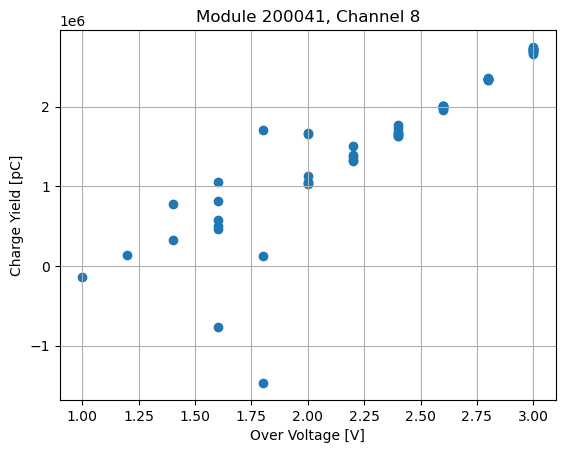

In [15]:
CH = 8
OV = 2

tt_charge = []
ov_tt_charge = []

for imod, module in enumerate(modules):
    mid, ov, tt = module['id'], module['ov'], module['tt']

    charges = module['src_charge']
    # if (charges == 0).any():
    #     continue

    if ov == OV:
        tt_charge.append([tt,charges[CH,0],charges[CH,0]])

    ov_tt_charge.append([ov,tt,charges[CH,0], charges[CH,1]])


tt_charge = np.array(tt_charge)
ov_tt_charge = np.array(ov_tt_charge)
# plt.scatter(1000*tt_charge[:,0], tt_charge[:,0])
plt.scatter(ov_tt_charge[:,0], ov_tt_charge[:,2])
# plt.xlabel('Trigger Threshold [mV]')
plt.xlabel('Over Voltage [V]')
plt.ylabel('Charge Yield [pC]')
plt.title(f'Module {mid}, Channel {CH}')
plt.grid()

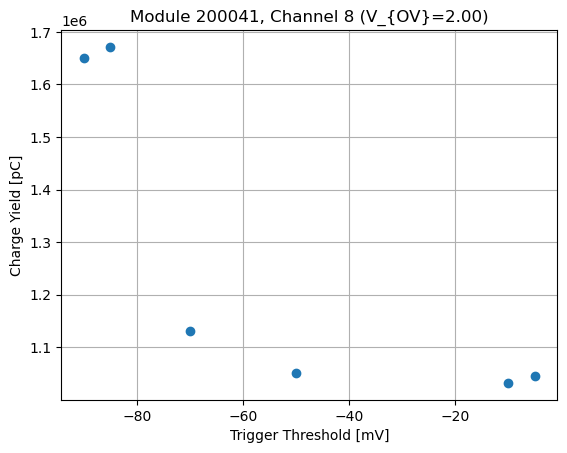

In [16]:
plt.scatter(1000*tt_charge[:,0], tt_charge[:,1])
# plt.scatter(ov_tt_charge[:,0], ov_tt_charge[:,2])
plt.xlabel('Trigger Threshold [mV]')
# plt.xlabel('Over Voltage [V]')
plt.ylabel('Charge Yield [pC]')
plt.title(f'Module {mid}, Channel {CH} (V_{{OV}}={OV:.2f})')
plt.grid()

# Charge/Light Yield Plots

# Crosstalk Plots

# Module Comparison Plots

# Etc

In [8]:
raise

RuntimeError: No active exception to reraise

In [ ]:
c = TCanvas('','',800,800)
c.SetGrid()
# c.SetLogz()
c.SetLeftMargin(0.1)
c.SetRightMargin(0.15)

chs = [0,1,2,3,4,5,6,7]
# chs = [24+ch for ch in chs]

h2D = TH2D('','Fraction of Triggered Event\'s Integrated Charge;Trigger Channel;Observed Channel',8,min(chs)-0.5,max(chs)+0.5,8,min(chs)-0.5,max(chs)+0.5)
latex = TLatex()
latex.SetTextAlign(22)
latex.SetTextSize(0.025)

aves = []

for ich_trg, ch_trg in enumerate(chs):
    frdf = rdf.Filter(f'channelTriggered == {ch_trg}')
    for ich_obs, ch_obs in enumerate(chs):
        if ich_trg == ich_obs:
            continue

        frdf = frdf.Define(f'ch{ch_obs}_tr{ch_trg}_charge', f'ch{ch_obs}_charge / ch{ch_trg}_charge')
        ave = frdf.Mean(f'ch{ch_obs}_tr{ch_trg}_charge').GetValue()
        std = frdf.StdDev(f'ch{ch_obs}_tr{ch_trg}_charge').GetValue()
        h2D.Fill(ch_trg,ch_obs,ave)
        # print(ch_trg,ch_obs,f'{ave:4.2f} #pm {std:4.2f}')
        print(f'[ {ch_trg}, {ch_obs}, {ave}, {std} ],')
        aves.append((ch_trg,ch_obs,f'{ave:4.2f}'))
        # latex.DrawLatex(ch_trg,ch_obs,f'{ave:4.2f}')#\n#pm{std:4.2f}')
        
h2D.Draw('colz')

for x, y, l  in aves:
    latex.DrawLatex(x,y,l)

c.Draw()

In [ ]:
import numpy as np
crosstalk = np.array([
    [ 0, 1, 0.09281597629374172, 0.14049757663933102 ],
    [ 0, 2, -0.0012366829254403528, 0.06814163411677451 ],
    [ 0, 3, -0.016298712431242732, 0.044356682484928175 ],
    [ 0, 4, -0.02062530799976462, 0.04018341609840911 ],
    [ 0, 5, -0.02380662713872635, 0.038324558541531564 ],
    [ 0, 6, -0.02097621014226779, 0.030735772197825598 ],
    [ 0, 7, -0.022073901113155544, 0.03714966714426945 ],
    [ 1, 0, 0.08326500953163235, 0.11271032168214228 ],
    [ 1, 2, 0.08025676630259948, 0.14008938577309804 ],
    [ 1, 3, -0.0013707371999284192, 0.06642585563570816 ],
    [ 1, 4, -0.01528786712846438, 0.04758054663453511 ],
    [ 1, 5, -0.02156113806139801, 0.04467888613138246 ],
    [ 1, 6, -0.020362196540161873, 0.034543150703329646 ],
    [ 1, 7, -0.022099732617734093, 0.03326592781627443 ],
    [ 2, 0, 0.00047357705562172737, 0.051830882179640186 ],
    [ 2, 1, 0.12350844078332131, 0.10555453856074283 ],
    [ 2, 3, 0.06869730083310595, 0.12374349172748367 ],
    [ 2, 4, -0.0032914526814243616, 0.058233136298331205 ],
    [ 2, 5, -0.016613056413260465, 0.046486887211078014 ],
    [ 2, 6, -0.018271524216589046, 0.03866469960547013 ],
    [ 2, 7, -0.020962105025808052, 0.03431110548177737 ],
    [ 3, 0, -0.01786877902620289, 0.04252715502382507 ],
    [ 3, 1, 0.004777524113499133, 0.057165613183099075 ],
    [ 3, 2, 0.10448377971764584, 0.1100600291788875 ],
    [ 3, 4, 0.0757617622645363, 0.13443273264504488 ],
    [ 3, 5, 0.005198057888866264, 0.06510166525479609 ],
    [ 3, 6, -0.01189539115588243, 0.04114200079211101 ],
    [ 3, 7, -0.01768489705107968, 0.04093348031976111 ],
    [ 4, 0, -0.025156547206955072, 0.03750469621492119 ],
    [ 4, 1, -0.017418773411421742, 0.0425601191946466 ],
    [ 4, 2, -8.406030089447125e-05, 0.056655836194777806 ],
    [ 4, 3, 0.1113619767240892, 0.11546355551046049 ],
    [ 4, 5, 0.1001077113957173, 0.13260452430556582 ],
    [ 4, 6, 0.0083624433258039, 0.06262515436106941 ],
    [ 4, 7, -0.009493404709174749, 0.04909715549738985 ],
    [ 5, 0, -0.021552612459874214, 0.030347799797648033 ],
    [ 5, 1, -0.019770105041877668, 0.03299025118125677 ],
    [ 5, 2, -0.015443876719280603, 0.036527333146671705 ],
    [ 5, 3, 0.003943857296224298, 0.057893882626322564 ],
    [ 5, 4, 0.08159026601621572, 0.13030051031422102 ],
    [ 5, 6, 0.0954330011502292, 0.14365695417515364 ],
    [ 5, 7, 0.012377578173279266, 0.06697155179563628 ],
    [ 6, 0, -0.026979853720657226, 0.0373885674635225 ],
    [ 6, 1, -0.026624251019315155, 0.03679422425997755 ],
    [ 6, 2, -0.02454687536811893, 0.03573722547798203 ],
    [ 6, 3, -0.015453219927217751, 0.03999943121695177 ],
    [ 6, 4, 0.0023407146262910006, 0.05872209241209839 ],
    [ 6, 5, 0.1288090210644232, 0.12069382176562397 ],
    [ 6, 7, 0.11306919812574091, 0.12747091656739665 ],
    [ 7, 0, -0.0262007246278004, 0.033765049294813484 ],
    [ 7, 1, -0.026274134135872273, 0.032978861945667994 ],
    [ 7, 2, -0.025355163929440906, 0.03830588300804836 ],
    [ 7, 3, -0.019814845095460804, 0.03758147722028174 ],
    [ 7, 4, -0.013503337174661968, 0.04332785637793121 ],
    [ 7, 5, 0.010256905854161972, 0.06382823729342428 ],
    [ 7, 6, 0.10125343718691657, 0.13049507962854487 ],
    [ 8, 9, 0.08377506737452668, 0.11608613334704762 ],
    [ 8, 10, -0.0026397109348906852, 0.05583597582012068 ],
    [ 8, 11, -0.014571773559633742, 0.038709385855498823 ],
    [ 8, 12, -0.01990341725679772, 0.03676791314719083 ],
    [ 8, 13, -0.023232241701965615, 0.0343488769443653 ],
    [ 8, 14, -0.021203922794324793, 0.030512758911830338 ],
    [ 8, 15, -0.0230195125548714, 0.0288020922553729 ],
    [ 9, 8, 0.10617162596802245, 0.22515416834343038 ],
    [ 9, 10, 0.06501159485962524, 0.11247475973755594 ],
    [ 9, 11, 0.004881060357638766, 0.051856649844875986 ],
    [ 9, 12, -0.013983081459773698, 0.04246318117435003 ],
    [ 9, 13, -0.020516988731219737, 0.03995365279533494 ],
    [ 9, 14, -0.021084378256145, 0.03250026281857136 ],
    [ 9, 15, -0.02329275451815494, 0.032321432177152415 ],
    [ 10, 8, 0.004361585133462468, 0.05888459524387288 ],
    [ 10, 9, 0.12002674999359778, 0.11594674626545765 ],
    [ 10, 11, 0.0799279850300938, 0.10240439088049905 ],
    [ 10, 12, 0.006325836384671096, 0.054841835890791814 ],
    [ 10, 13, -0.011356891326537262, 0.0452435954149803 ],
    [ 10, 14, -0.019000291966286338, 0.03623142203347868 ],
    [ 10, 15, -0.02308867925645928, 0.03144217783565141 ],
    [ 11, 8, -0.016740541430092445, 0.046780993665826914 ],
    [ 11, 9, 0.008346251009151621, 0.06298766383857834 ],
    [ 11, 10, 0.10038528994381793, 0.12991339437873686 ],
    [ 11, 12, 0.08139565594504623, 0.10411490492591385 ],
    [ 11, 13, 0.01566947369338378, 0.05472265161446232 ],
    [ 11, 14, -0.012302998633625337, 0.03504983063379966 ],
    [ 11, 15, -0.020315959602190993, 0.03463955232286712 ],
    [ 12, 8, -0.02377289417467931, 0.03818780393787838 ],
    [ 12, 9, -0.015904608899299438, 0.04352275987143053 ],
    [ 12, 10, 0.005489137579098339, 0.06321375436589462 ],
    [ 12, 11, 0.10665602497327428, 0.13086307797652952 ],
    [ 12, 13, 0.10759533305738996, 0.10259716443903458 ],
    [ 12, 14, 0.004365286288051362, 0.0478524632192113 ],
    [ 12, 15, -0.015474412647178595, 0.041118501440245536 ],
    [ 13, 8, -0.02171678847882032, 0.07316693171817415 ],
    [ 13, 9, -0.019159943622660446, 0.03814312652577364 ],
    [ 13, 10, -0.012427668465390368, 0.0471548530306067 ],
    [ 13, 11, 0.010511800740485371, 0.062250732175639464 ],
    [ 13, 12, 0.10079030174515309, 0.1279428604285017 ],
    [ 13, 14, 0.06553427462722539, 0.11420408933288592 ],
    [ 13, 15, -0.002067149695348521, 0.05257390955630809 ],
    [ 14, 8, -0.03580129792557812, 1.1553697660534918 ],
    [ 14, 9, -0.028913280666532898, 0.2303533996682135 ],
    [ 14, 10, -0.024376045019672946, 0.04247664295046934 ],
    [ 14, 11, -0.014427041615759606, 0.046924006608781405 ],
    [ 14, 12, 0.0066564576048415165, 0.059334289446425284 ],
    [ 14, 13, 0.14816578495326185, 0.13004109000725445 ],
    [ 14, 15, 0.059263195355132185, 0.10542398618180629 ],
    [ 15, 8, -0.026921566597579206, 0.035512595780971455 ],
    [ 15, 9, -0.02692346623434937, 0.03834329406270523 ],
    [ 15, 10, -0.026045971207438064, 0.034335570897548746 ],
    [ 15, 11, -0.020947931829666797, 0.03432999666900487 ],
    [ 15, 12, -0.012920599909677172, 0.04478792919015817 ],
    [ 15, 13, 0.012578434578013279, 0.07363381576814822 ],
    [ 15, 14, 0.10412410998321851, 0.12567459657631186 ],
    [ 16, 17, 0.13979189707440248, 0.13413088109350124 ],
    [ 16, 18, 0.007722300109872769, 0.06490574774779909 ],
    [ 16, 19, -0.009522489426960438, 0.042238030908555824 ],
    [ 16, 20, -0.016544919385202715, 0.03824515965131357 ],
    [ 16, 21, -0.019749339065484806, 0.03296610370139176 ],
    [ 16, 22, -0.020634267174761807, 0.03326230569816036 ],
    [ 16, 23, -0.02175798771688324, 0.032762311464113396 ],
    [ 17, 16, 0.06620225687871022, 0.11401463037859781 ],
    [ 17, 18, 0.11899732523620617, 0.13418949288791676 ],
    [ 17, 19, 0.010892268903381797, 0.06634307561685429 ],
    [ 17, 20, -0.009279052487692022, 0.04840709675167052 ],
    [ 17, 21, -0.017746750180913862, 0.03959295158276443 ],
    [ 17, 22, -0.01982442056312908, 0.03319216796564805 ],
    [ 17, 23, -0.02165249363563073, 0.03265994533638874 ],
    [ 18, 16, 0.002140313551961005, 0.05032510362348499 ],
    [ 18, 17, 0.10855898730794204, 0.1080276053325413 ],
    [ 18, 19, 0.13153630301951516, 0.12062886293389269 ],
    [ 18, 20, 0.009146457373352991, 0.05970408442450417 ],
    [ 18, 21, -0.01354781250404149, 0.042428166707055945 ],
    [ 18, 22, -0.017183397573584808, 0.040647497282189804 ],
    [ 18, 23, -0.020777933997088008, 0.031303733357472885 ],
    [ 19, 16, -0.01223763493973813, 0.03927061681978305 ],
    [ 19, 17, 0.007287794844337716, 0.057798047885456956 ],
    [ 19, 18, 0.0754895925988197, 0.10960561740024397 ],
    [ 19, 20, 0.1337747421875586, 0.1265313507854564 ],
    [ 19, 21, 0.007906075169285019, 0.06361256053630557 ],
    [ 19, 22, -0.007331354973821934, 0.041559254813582074 ],
    [ 19, 23, -0.015673446496662267, 0.03618392811636426 ],
    [ 20, 16, -0.017891047269832202, 0.03164082120709339 ],
    [ 20, 17, -0.010648724551190798, 0.03820527534829957 ],
    [ 20, 18, 0.0005492078899581334, 0.050450970836695606 ],
    [ 20, 19, 0.08897920567023218, 0.11765523648869383 ],
    [ 20, 21, 0.11624409405322908, 0.13403384178603656 ],
    [ 20, 22, 0.018348098784119242, 0.06239878594949959 ],
    [ 20, 23, -0.007010618097506475, 0.0429233266540312 ],
    [ 21, 16, -0.02253010108214388, 0.03464683755505451 ],
    [ 21, 17, -0.019507633297348434, 0.03870544698637989 ],
    [ 21, 18, -0.015131926775470773, 0.0413644986732744 ],
    [ 21, 19, 0.008656750883094911, 0.05712993187394225 ],
    [ 21, 20, 0.09379311105605062, 0.12708068625800703 ],
    [ 21, 22, 0.1795910251356525, 0.12349328289327689 ],
    [ 21, 23, 0.019253143712849558, 0.06869666155180194 ],
    [ 22, 16, -0.02000464421721582, 0.029880856053265344 ],
    [ 22, 17, -0.018649303673797555, 0.03378776479704946 ],
    [ 22, 18, -0.016932522789283148, 0.03218568962236295 ],
    [ 22, 19, -0.008684284067275299, 0.036524162893829586 ],
    [ 22, 20, 0.009036029964849595, 0.05795379727702692 ],
    [ 22, 21, 0.07966404768503688, 0.14619738499574556 ],
    [ 22, 23, 0.1377798416261163, 0.12089353319609993 ],
    [ 23, 16, -0.01973014904345551, 0.03077007854700119 ],
    [ 23, 17, -0.018826526451739458, 0.03047174398995876 ],
    [ 23, 18, -0.017961293424148657, 0.03679378480022455 ],
    [ 23, 19, -0.013453016254397182, 0.03725722658723708 ],
    [ 23, 20, -0.00782743228985578, 0.042197083336044126 ],
    [ 23, 21, 0.0047510600424316715, 0.06561802383433399 ],
    [ 23, 22, 0.09031739160045224, 0.13394464712861975 ],
    [ 24, 25, 0.13049541262919023, 0.10882035714414107 ],
    [ 24, 26, 0.0064946733118432425, 0.052301176272015686 ],
    [ 24, 27, -0.00744601747246489, 0.03784731232713598 ],
    [ 24, 28, -0.01610459900810709, 0.03487196712719033 ],
    [ 24, 29, -0.018865091752175177, 0.03167678411213489 ],
    [ 24, 30, -0.020952982521435008, 0.03012034992285343 ],
    [ 24, 31, -0.022732596417655893, 0.02590703335357812 ],
    [ 25, 24, 0.08872682232941627, 0.1317526318369451 ],
    [ 25, 26, 0.11167334119558261, 0.10739488347978832 ],
    [ 25, 27, 0.01847761485019008, 0.05265850044956628 ],
    [ 25, 28, -0.008397264223725087, 0.040755527509757805 ],
    [ 25, 29, -0.016543146920073797, 0.03360296330890415 ],
    [ 25, 30, -0.02096436506339269, 0.032985186497805914 ],
    [ 25, 31, -0.02345721957219163, 0.027694941136273937 ],
    [ 26, 24, 0.006792928878133214, 0.1173982136032028 ],
    [ 26, 25, 0.0956500108072439, 0.11755344038193773 ],
    [ 26, 27, 0.14114595365180013, 0.09446950614789013 ],
    [ 26, 28, 0.017192253617568484, 0.0517484862654501 ],
    [ 26, 29, -0.0069589837206038155, 0.040582159629334716 ],
    [ 26, 30, -0.01797791790610786, 0.03613454513393844 ],
    [ 26, 31, -0.022088060464437495, 0.030524689656204494 ],
    [ 27, 24, -0.010523824572481591, 0.0445263108999315 ],
    [ 27, 25, 0.010882814386598808, 0.06054391745279092 ],
    [ 27, 26, 0.07310612937759538, 0.12727481386524278 ],
    [ 27, 28, 0.1340831726590416, 0.0972988677005552 ],
    [ 27, 29, 0.015935562864350168, 0.052056488134064695 ],
    [ 27, 30, -0.010202264156624657, 0.035646954188992296 ],
    [ 27, 31, -0.0192830951155652, 0.03172886854200261 ],
    [ 28, 24, -0.01679600373009274, 0.03565907596297978 ],
    [ 28, 25, -0.008875007679543356, 0.03978593446720687 ],
    [ 28, 26, 0.00851389817163661, 0.06196195587031178 ],
    [ 28, 27, 0.09001618776059542, 0.1313207413815517 ],
    [ 28, 29, 0.13095238884250537, 0.09856811766919103 ],
    [ 28, 30, 0.010475360327967736, 0.046550914924700704 ],
    [ 28, 31, -0.012474107543910063, 0.03827820402218173 ],
    [ 29, 24, -0.019588100094986093, 0.039752632880510036 ],
    [ 29, 25, -0.01607842288097258, 0.041521250777693836 ],
    [ 29, 26, -0.009662502091059873, 0.05178208956754165 ],
    [ 29, 27, 0.015133220849997811, 0.06759469850134674 ],
    [ 29, 28, 0.08954402559129232, 0.14097784781757833 ],
    [ 29, 30, 0.10991561121154482, 0.11053759609028334 ],
    [ 29, 31, -0.0006179807682138971, 0.052610760770061896 ],
    [ 30, 24, 0.04372609578642628, 8.980062338580158 ],
    [ 30, 25, -0.009900111668968608, 1.3025306331252435 ],
    [ 30, 26, -0.013610874753633456, 0.444705341919598 ],
    [ 30, 27, -0.007795241216455898, 0.13972446755368964 ],
    [ 30, 28, 0.006528964308761164, 0.06460499372238061 ],
    [ 30, 29, 0.08585057019345965, 0.15803381463441182 ],
    [ 30, 31, 0.0918053260726429, 0.10201680104287263 ],
    [ 31, 24, -0.020329849768788027, 0.03406922026404564 ],
    [ 31, 25, -0.019311234988603175, 0.03651847336518603 ],
    [ 31, 26, -0.018665130997581908, 0.03215379635057981 ],
    [ 31, 27, -0.015083765470395045, 0.032597320562138675 ],
    [ 31, 28, -0.009654106257081145, 0.045512313541848815 ],
    [ 31, 29, 0.007981035272517222, 0.07001220370899068 ],
    [ 31, 30, 0.07886553593028404, 0.13054771063867127 ],
])

canvas = TCanvas('','',1200,800)
canvas.Clear()
canvas.SetGrid()
canvas.SetRightMargin(0.05)
# canvas.SetLeftMargin(0.15)

legend = TLegend(*(0.16, 0.12, 0.55, 0.32))
legend.SetTextSize(0.026)
legend.SetMargin(0.1)

latex = TLatex()
latex.SetTextAlign(11)
latex.SetTextSize(0.04)


l_array = crosstalk[crosstalk[:,0] < 16]
r_array = crosstalk[crosstalk[:,0] >= 16]
r_array[:,:2] = r_array[:,:2] - 16

l_ct_l_array = l_array[l_array[:,0]-l_array[:,1] == -1]
r_ct_l_array = l_array[l_array[:,0]-l_array[:,1] == 1]
a_ct_l_array = (np.r_[[[0,0,0,0]],l_ct_l_array] + np.r_[r_ct_l_array,[[0,0,0,0]]])/2
a_ct_l_array[0], a_ct_l_array[-1] = 2*a_ct_l_array[0], 2*a_ct_l_array[-1]
l_ct_r_array = r_array[r_array[:,0]-r_array[:,1] == -1]
r_ct_r_array = r_array[r_array[:,0]-r_array[:,1] == 1]

grll = TGraph(len(l_ct_l_array),l_ct_l_array[:,0]*1.,l_ct_l_array[:,2]*1.)
grrl = TGraph(len(r_ct_l_array),r_ct_l_array[:,0]*1.,r_ct_l_array[:,2]*1.)
grlr = TGraph(len(l_ct_r_array),l_ct_r_array[:,0]*1.,l_ct_r_array[:,2]*1.)
grrr = TGraph(len(r_ct_r_array),r_ct_r_array[:,0]*1.,r_ct_r_array[:,2]*1.)

grll.SetName('Left SiPM, CT in CH_{trig}-1')
grrl.SetName('Left SiPM, CT in CH_{trig}+1')
grlr.SetName('Right SiPM, CT in CH_{trig}-1')
grrr.SetName('Right SiPM, CT in CH_{trig}+1')

grs = [grll, grrl, grlr, grrr]
arrs = [l_ct_l_array, r_ct_l_array, l_ct_r_array, r_ct_r_array]
for igr, gr in enumerate(grs):
    gr.SetTitle('Crosstalk in neighboring channel')
    gr.GetXaxis().SetTitle('Trigger Channel (Bar)')
    gr.GetYaxis().SetTitle('Fraction of Trigger Channel\'s Charge')
    gr.GetXaxis().SetLimits(-0.5, 15.5)
    gr.SetMinimum(0.0)
    gr.SetMaximum(0.2)

    gr.SetLineWidth(1)
    gr.SetLineColor([rt.kRed, rt.kBlue][igr // 2])
    gr.SetMarkerSize(2)
    gr.SetMarkerColor(gr.GetLineColor())
    gr.SetMarkerStyle([rt.kFullTriangleUp,rt.kFullTriangleDown][igr % 2])

    gr.Draw(('' if igr else 'A') + 'LP')

    ave, std = np.mean(arrs[igr][:,2]), np.std(arrs[igr][:,2])
    legend.AddEntry(gr, gr.GetName()+f' (ave = {ave:.2f} #pm {std:.2f})', 'LP')
    # latex.SetTextColor(gr.GetLineColor())

        # a, e = ly.mean(), ly.std()
        # # latex.DrawLatexNDC(0.19, 0.86 - 0.05*igr, f'yield: mean={a:.0f}, rmse={e:.1f}, mae={100*np.abs((ly-a)).mean()/a:.1f}%')
        # if a < 10:
        #     latex.DrawLatexNDC(0.45, 0.86 - 0.05*igr, f'mean={a:>3.1f}, rmse={100*e/a:>4.1f}%')
        # else:
        #     latex.DrawLatexNDC(0.45, 0.86 - 0.05*igr, f'mean={a:>3.0f}, rmse={100*e/a:>4.1f}%')
        # # latex.DrawLatexNDC(0.19, 0.86 - 0.05*igr, f'average light yield: {a:.0f} #pm {e:.2f} ({100*e/a:.0f}%)')


legend.Draw()
canvas.Draw()
    # canvas.Print(f'{PLOT_DIR}/module_{mid}_{"_".join(titles[igrs].split(" ")[:2]).lower()}_yield.png')

In [ ]:
c = TCanvas('','',800,800)
c.SetGrid()
c.SetLogy()

legend = TLegend(0.69, 0.79, 0.89, 0.89)

ch = 0
form = ('',f'Channel {ch} Integrated Charge;Charge [pC];count',100,0,700)

h1 = rdf.Histo1D(form,f'ch{ch}_IntegratedCharge').GetValue()
h2 = rdf.Filter(f'channelTriggered == {ch}').Histo1D(form,f'ch{ch}_IntegratedCharge').GetValue()

h1.SetLineColor(STD_COLOR_LIST[0])
h2.SetLineColor(STD_COLOR_LIST[1])

h1.SetLineWidth(2)
h2.SetLineWidth(2)

h1.Draw()
h2.Draw('same')

legend.AddEntry(h1, 'All Events', 'L')
legend.AddEntry(h2, 'Trig Events', 'L')

legend.Draw()
c.Draw()

In [ ]:
c = TCanvas('','',800,800)
c.SetGrid()
c.SetLogy()

legend = TLegend(0.69, 0.59, 0.89, 0.89)

ch = 0
form = ('',f'Channel {ch} Integrated Charge;Charge [pC];count',300,0,700)

h0 = rdf.Histo1D(form,f'ch{ch}_IntegratedCharge').GetValue()
h0.SetLineColor(STD_COLOR_LIST[0])
h0.SetLineWidth(2)
h0.Draw()
legend.AddEntry(h0, 'All Events', 'L')

for ich, _ch in enumerate([0, 1, 2, 3]):
    hh = rdf.Filter(f'channelTriggered == {_ch}').Histo1D(form,f'ch{ch}_IntegratedCharge').GetValue()
    hh.SetLineColor(STD_COLOR_LIST[ich+1])
    hh.SetLineWidth(2)
    hh.Draw('same')
    legend.AddEntry(hh, f'Ch{_ch} Trig', 'L')
    gc.append(hh)

legend.Draw()
c.Draw()

In [ ]:
h0.GetXaxis().GetBinCenter(h0.GetMaximumBin())

In [ ]:
c = TCanvas('','',800,800)
c.SetGrid()
# c.SetLogy()

legend = TLegend(0.69, 0.59, 0.89, 0.89)

ch = 0
form = ('',f'Channel {ch} Integrated Charge;Charge [pC];count',200,50,300)

h0 = rdf.Histo1D(form,f'ch{ch}_IntegratedCharge').GetValue()
h0.SetLineColor(STD_COLOR_LIST[0])
h0.SetLineWidth(2)
h0.Draw()
legend.AddEntry(h0, 'All Events', 'L')

for ich, _ch in enumerate([0, 1, 2, 3]):
    hh = rdf.Filter(f'channelTriggered == {_ch}').Histo1D(form,f'ch{ch}_IntegratedCharge').GetValue()
    hh.SetLineColor(STD_COLOR_LIST[ich+1])
    hh.SetLineWidth(2)
    hh.Draw('same')
    legend.AddEntry(hh, f'Ch{_ch} Trig', 'L')
    gc.append(hh)

legend.Draw()
c.Draw()

In [ ]:
c = TCanvas('','',800,800)
c.SetGrid()
c.SetLogy()

legend = TLegend(0.69, 0.59, 0.89, 0.89)

ch = 0
form = ('',f'Channel {ch} Integrated Charge;Charge [pC];count',100,0,700)

h0 = rdf.Filter(f'ch{ch}_satFlag == 1').Histo1D(form,f'ch{ch}_IntegratedCharge').GetValue()
h0.SetLineColor(STD_COLOR_LIST[0])
h0.SetLineWidth(2)
h0.Draw()
legend.AddEntry(h0, 'All Events', 'L')

for ich, _ch in enumerate([0, 1, 2, 3]):
    hh = rdf.Filter(f'channelTriggered == {_ch} && (ch{ch}_satFlag == 1)').Histo1D(form,f'ch{ch}_IntegratedCharge').GetValue()
    hh.SetLineColor(STD_COLOR_LIST[ich+1])
    hh.SetLineWidth(2)
    hh.Draw('same')
    legend.AddEntry(hh, f'Ch{_ch} Trig', 'L')
    gc.append(hh)

legend.Draw()
c.Draw()

In [ ]:
c = TCanvas('','',800,800)
c.SetGrid()
# c.SetLogz()
c.SetLeftMargin(0.15)
c.SetRightMargin(0.15)

chs = [0,1,2,3,5,6,7]
chs = [16+ch for ch in chs]

h2D = TH2D('','Fraction of Triggered Event\'s Integrated Charge;Trigger Channel;Observed Channel',4,min(chs)-0.5,max(chs)+0.5,4,min(chs)-0.5,max(chs)+0.5)
latex = TLatex()
latex.SetTextAlign(22)
latex.SetTextSize(0.05)

aves = []

for ich_trg, ch_trg in enumerate(chs):
    frdf = rdf.Filter(f'channelTriggered == {ch_trg}')
    for ich_obs, ch_obs in enumerate(chs):
        if ich_trg == ich_obs:
            continue

        frdf = frdf.Define(f'ch{ch_obs}_{ch_trg}_IntegratedCharge', f'ch{ch_obs}_IntegratedCharge / ch{ch_trg}_IntegratedCharge')
        ave = frdf.Mean(f'ch{ch_obs}_{ch_trg}_IntegratedCharge').GetValue()
        std = frdf.StdDev(f'ch{ch_obs}_{ch_trg}_IntegratedCharge').GetValue()
        h2D.Fill(ch_trg,ch_obs,ave)
        # print(ch_trg,ch_obs,f'{ave:4.2f} #pm {std:4.2f}')
        print(f'[ {ch_trg}, {ch_obs}, {ave}, {std} ],')
        aves.append((ch_trg,ch_obs,f'{ave:4.2f}'))
        # latex.DrawLatex(ch_trg,ch_obs,f'{ave:4.2f}')#\n#pm{std:4.2f}')
        
h2D.Draw('colz')

for x, y, l  in aves:
    latex.DrawLatex(x,y,l)

c.Draw()

In [ ]:
form = ('','',100,-700,300)
c = TCanvas('','',800,800)
c.SetLogy()
h1 = rdf.Histo1D(form,'ch0_t10')
h2 = rdf.Histo1D(form,'ch0_t90')
# h2 = rdf.Filter('ch0_triggerBool == 1').Histo1D(('','',100,0,500),'ch0_t10')

h1.SetLineColor(rt.kBlack)
h2.SetLineColor(rt.kAzure)

h1.DrawNormalized()
h2.DrawNormalized('same')
c.Draw()

In [ ]:
form = ('','',100,0,100)
c = TCanvas('','',800,800)
c.SetLogy()
h1 = rdf.Histo1D(form,'ch0_t')
h2 = rdf.Histo1D(form,'ch1_t')
h3 = rdf.Histo1D(form,'ch2_t')
h4 = rdf.Histo1D(form,'ch3_t')
# h2 = rdf.Filter('ch0_triggerBool == 1').Histo1D(('','',100,0,500),'ch0_t10')

h1.SetLineColor(rt.kBlack)
h2.SetLineColor(rt.kRed)
h3.SetLineColor(rt.kAzure)
h4.SetLineColor(rt.kMagenta)

h1.Draw()
h2.Draw('same')
h3.Draw('same')
h4.Draw('same')
c.Draw()

In [ ]:
form = ('','Integration Time;t_{10%} [ps?];t_{90%} [ps?]',100,-450,-300,100,-450,-300)
c = TCanvas('','',1600,800)
c.Divide(2,1)
# c.SetLogy()
c.cd(1).SetGrid()
c.cd(1).SetLogz()
h1 = rdf.Histo2D(form,'ch0_t10','ch0_t90')
h1.Draw()

c.cd(2).SetGrid()
c.cd(2).SetLogz()
h2 = rdf.Filter('channelTriggered == 0').Histo2D(form,'ch0_t10','ch0_t90')
h2.Draw()

c.Draw()

In [ ]:
ch = 0

for ch in (0, 1, 2, 3):
    form = ('',f'Channel {ch} Integration Time vs Charge;Charge [pC];|t_{{90%}}-t_{{10%}}|',50,0,600,50,0,30)
    frdf = rdf.Filter(f'channelTriggered == {ch}')

    c = TCanvas('','',1600,800)
    c.Divide(2,1)
    c.cd(1).SetGrid()
    c.cd(1).SetLogz()

    h1 = rdf.Histo2D(form,f'ch{ch}_IntegratedCharge',f'ch{ch}_t')
    h1.Draw()

    c.cd(2).SetGrid()
    c.cd(2).SetLogz()
    h2 = frdf.Histo2D(form,f'ch{ch}_IntegratedCharge',f'ch{ch}_t')
    h2.Draw()

    c.Draw()
    gc.extend([h1,h2])

    ave, std = frdf.Mean(f'ch{ch}_t'), frdf.StdDev(f'ch{ch}_t')
    print(f'Ch{ch} : {ave.GetValue():.2f} +/- {std.GetValue():.2f}')